In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("../input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input\churn_modelling\Churn_Modelling.csv
../input\heartbeat\mitbih_test.csv
../input\heartbeat\mitbih_train.csv
../input\heartbeat\ptbdb_abnormal.csv
../input\heartbeat\ptbdb_normal.csv
../input\insurance\insurance.csv
../input\pimaindiansdiabetescsv\pima-indians-diabetes.csv
../input\telco-customer-churn\WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
data = pd.read_csv("../input/insurance/insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
without_categorical = pd.get_dummies(data)

In [4]:
without_categorical.columns
del without_categorical["sex_male"]
del without_categorical["smoker_no"]

In [5]:
y = without_categorical["charges"]
x = without_categorical.loc[:, without_categorical.columns != "charges"]

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=425
)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.transform(x_test)

In [8]:
from sklearn.tree import DecisionTreeRegressor

dtreg = DecisionTreeRegressor()
dtreg.fit(x_train_scale, y_train)
ypred = dtreg.predict(x_test_scale)

import sklearn.metrics as metrik

metrik.mean_absolute_error(y_pred=ypred, y_true=y_test)

3079.615391324627

MAE Absolute difference between the predicted and actual values for each data point, summing these differences, and then dividing by the total number of data points

In [11]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(x_train_scale, y_train)
ypred = knn.predict(x_test_scale)
metrik.mean_absolute_error(y_pred=ypred, y_true=y_test)

3587.5544081094527

In [10]:
import xgboost as xgb

xgreg = xgb.XGBRegressor()
xgreg.fit(x_train_scale, y_train)
ypred = xgreg.predict(x_test_scale)
metrik.mean_absolute_error(y_pred=ypred, y_true=y_test)

2882.718059372969

Fine Tune the XGboost is a option.

In [12]:
xgreg.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [13]:
parameters = {
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50, 0.85],

    "max_depth": [
        3,
        4,
        5,
        6,
        8,
        10,
    ],

    "min_child_weight": [1, 3, 5, 7, 9, 11],

    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],

    "n_estimators": [25, 50, 100, 150, 200],

    "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
}

In [14]:
from sklearn.model_selection import RandomizedSearchCV


clf = RandomizedSearchCV(xgb.XGBRegressor(), parameters, random_state=0)

search = clf.fit(x_train_scale, y_train)

search.best_params_

{'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 3,
 'learning_rate': 0.15,
 'gamma': 0.6,
 'colsample_bytree': 0.7}

In [15]:
xgreg = xgb.XGBRegressor(
    n_estimators=100,
    min_child_weight=3,
    max_depth=3,
    learning_rate=0.15,
    gamma=0.6,

    colsample_bytree=0.7,
)

xgreg.fit(x_train_scale, y_train)
ypred = xgreg.predict(x_test_scale)

metrik.mean_absolute_error(y_pred=ypred, y_true=y_test)

2517.8686886373307

Randomized CV works. GRİD SearchCV maybe work even better!

In [16]:
parameters2 = {
    "learning_rate": [0.08, 0.30, 0.60, 0.85],

    "max_depth": [3, 5, 6, 8],

    "min_child_weight": [1, 3, 5, 7],

    "gamma": [0.1, 0.3, 0.5, 0.7],

    "n_estimators": [50, 100, 150],

    "colsample_bytree": [0.3, 0.5, 0.7],
}

In [17]:
from sklearn.model_selection import GridSearchCV


clf = GridSearchCV(xgb.XGBRegressor(), parameters2, n_jobs=6)

search = clf.fit(x_train_scale, y_train)

search.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.1,
 'learning_rate': 0.08,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 100}

In [18]:
xgreg = xgb.XGBRegressor(
    n_estimators=100,
    min_child_weight=7,
    max_depth=3,
    learning_rate=0.08,
    gamma=0.1,

    colsample_bytree=0.7,
)

xgreg.fit(x_train_scale, y_train)
ypred = xgreg.predict(x_test_scale)

metrik.mean_absolute_error(y_pred=ypred, y_true=y_test)

2462.981078677851

Goes Better and better. 

In [19]:
xgreg.save_model("gridsearchparameters2.model")

d:\projects\boosting\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:49:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


XGBoost tuning work better than tpot with less time.

In [20]:
from tpot import TPOTRegressor

tpot = TPOTRegressor(verbosity=2, random_state=19, max_time_mins=70)
tpot.fit(x_train_scale, y_train)
ypred = tpot.predict(x_test_scale)
metrik.mean_absolute_error(y_pred=ypred, y_true=y_test)  # 2490

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -20686631.88648525

Generation 2 - Current best internal CV score: -20682749.284776337

Generation 3 - Current best internal CV score: -20682749.284776337

Generation 4 - Current best internal CV score: -20561414.196578898

Generation 5 - Current best internal CV score: -20561414.196578898


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.8, min_samples_leaf=8, min_samples_split=15, n_estimators=100)


2507.488242410268

In [21]:
tpot.export("insurance_tpot_pipeline.py")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

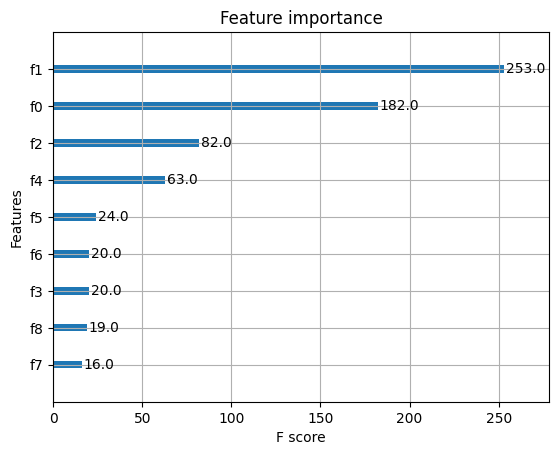

In [22]:
xgreg.feature_names = data.columns

xgb.plot_importance(xgreg)

I don't want to use scaling.

2462.981078677851


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

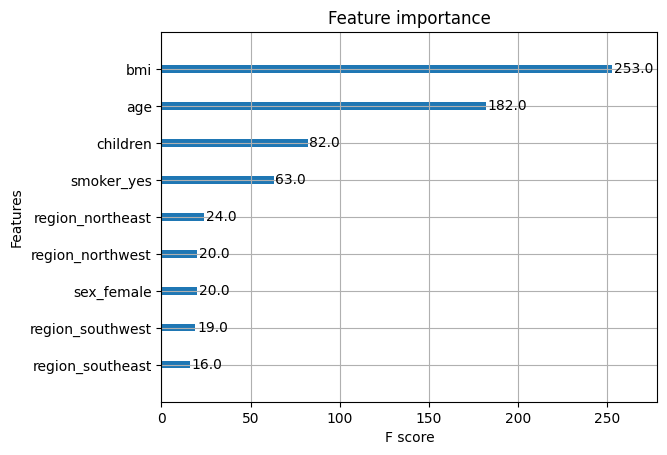

In [23]:
xgreg = xgb.XGBRegressor(
    n_estimators=100,
    min_child_weight=7,
    max_depth=3,
    learning_rate=0.08,
    gamma=0.1,

    colsample_bytree=0.7,
)

xgreg.fit(x_train, y_train)

ypred = xgreg.predict(x_test)

print(metrik.mean_absolute_error(y_pred=ypred, y_true=y_test))


xgb.plot_importance(xgreg)

Bmi is the most important feature. Age and Children also However smoking is less meaningful.

In [24]:
xgreg.save_model("betterexplained.model")

d:\projects\boosting\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:57:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [29]:
from pdpbox import pdp


# pdp_age_bmi = pdp.PDPIsolate(
#     model=xgreg,
#     df=x_train,
#     model_features=x_train.columns,
#     feature="age",
#     feature_name="bmi",
# )

#pdp.pdp_plot(pdp_age_bmi, feature_name="age")

İf age increase also the İnsurance cost increase. We clealy see this. 

In [31]:
# pdep = pdp.PDPIsolate(xgreg, x_train, x_train.columns, "bmi")
# pdp.pdp_plot(pdep, feature_name="bmi")

BMİ 35 to 50 has no difference. Equally Bad.

In [ ]:
# pdep = pdp.pdp_isolate(xgreg, x_train, x_train.columns, "smoker_yes")
# pdp.pdp_plot(pdep, feature_name="smoker_yes")

In [ ]:
# features = ["age", "bmi"]
# pdp.pdp_interact_plot(xgreg, features)

Maybe Xgboost regressor problem.

<Axes: >

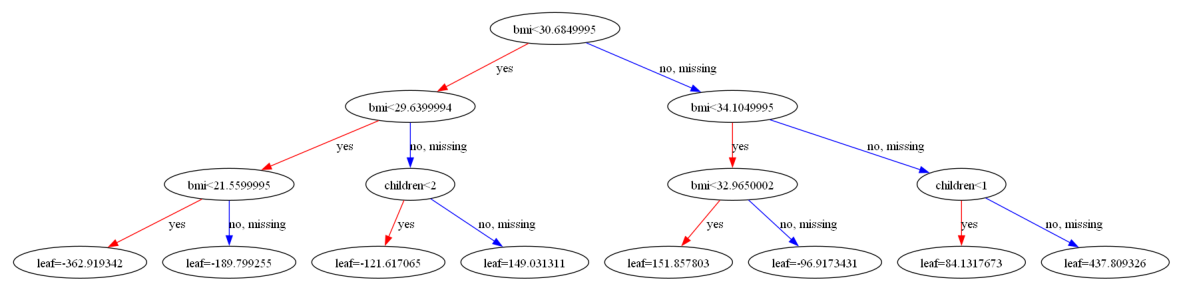

In [32]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(15, 15))

xgb.plot_tree(xgreg, num_trees=0, ax=ax)

Trees is complicated. Normally this cause to overfit.

<Axes: >

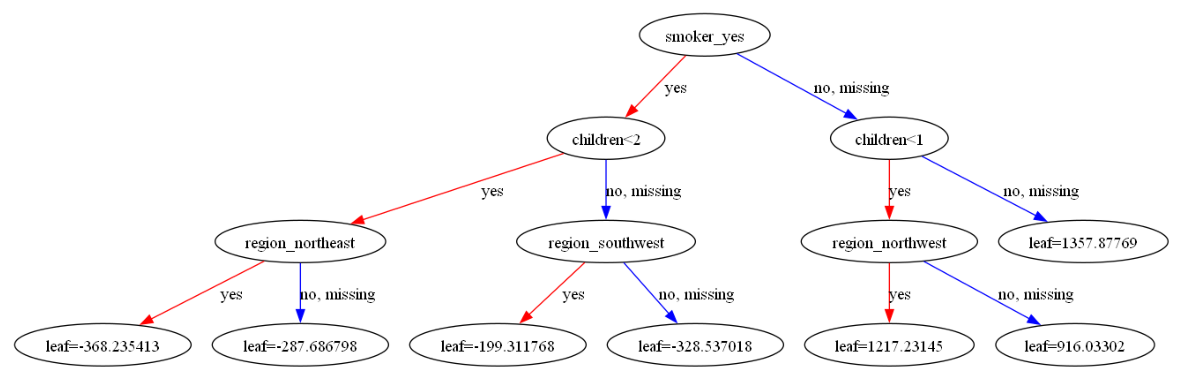

In [33]:
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(xgreg, num_trees=5, ax=ax)

Age and Smoking. 

<Axes: >

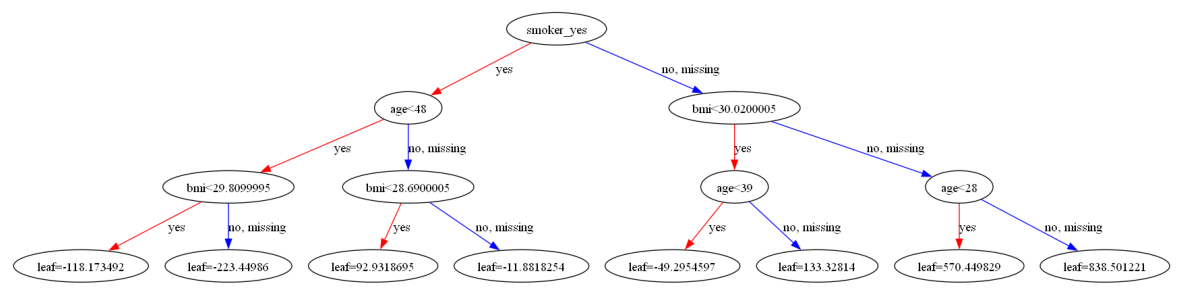

In [34]:
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(xgreg, num_trees=25, ax=ax)

<Axes: >

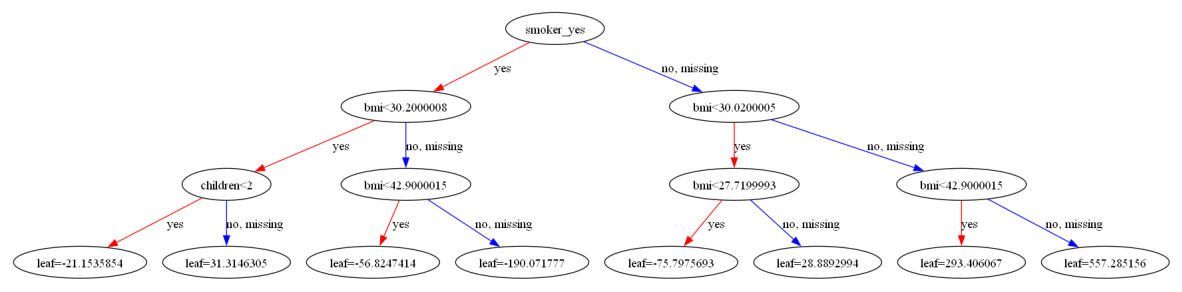

In [35]:
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(xgreg, num_trees=45, ax=ax)

With Max Depth: 2

In [36]:
xgreg2 = xgb.XGBRegressor(
    n_estimators=100,
    min_child_weight=7,
    max_depth=2,
    learning_rate=0.08,
    gamma=0.1,
    colsample_bytree=0.7,
)

xgreg2.fit(x_train, y_train)

ypred = xgreg2.predict(x_test)

print(metrik.mean_absolute_error(y_pred=ypred, y_true=y_test))

xgb.plot_importance(xgreg2)

xgreg2.save_model("maxdepth2.model")

ValueError: feature_names mismatch: ['age', 'bmi', 'children', 'sex_female', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'x'] ['age', 'bmi', 'children', 'sex_female', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
expected x in input data

Age is the most  important. And Also Mean Absolute error is good.

In [ ]:
pdep = pdp.pdp_isolate(xgreg2, x_train, x_train.columns, "age")
pdp.pdp_plot(pdep, feature_name="age")

In [ ]:
pdep = pdp.pdp_isolate(xgreg2, x_train, x_train.columns, "bmi")
pdp.pdp_plot(pdep, feature_name="bmi")

PDP results is nearly same.

<Axes: >

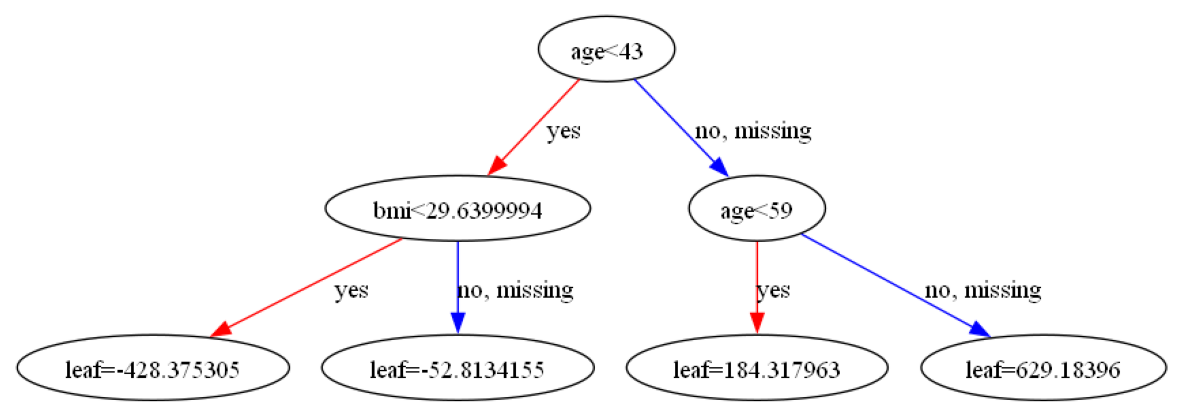

In [37]:
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(xgreg2, num_trees=0, ax=ax)

<Axes: >

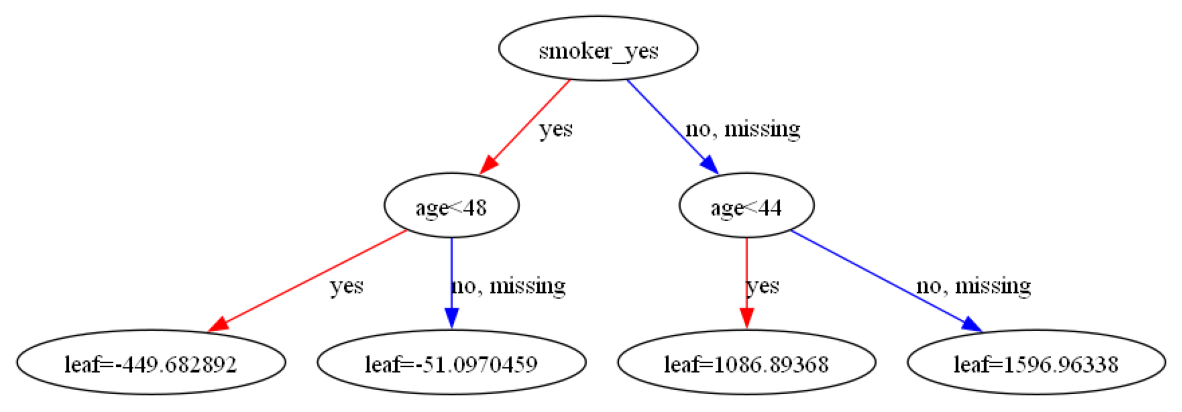

In [38]:
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(xgreg2, num_trees=5, ax=ax)

<Axes: >

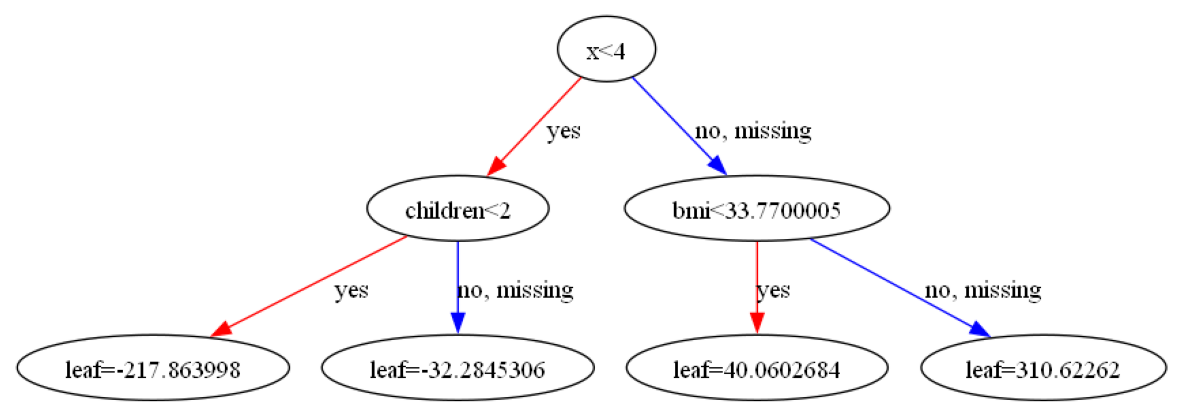

In [39]:
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(xgreg2, num_trees=10, ax=ax)

### I think Depth 2 version is better. 

In [40]:
import shap

In [41]:
shap.initjs()
explainer = shap.TreeExplainer(xgreg)

In [42]:
# shap_values = explainer.shap_values(x_train)

# shap.force_plot(explainer.expected_value, shap_values[0, :], x_train.iloc[0, :])

XGBoostError: [08:08:08] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api_utils.h:129: Check failed: std::accumulate(shape.cbegin(), shape.cend(), static_cast<bst_ulong>(1), std::multiplies<>{}) == chunksize * rows (11770 vs. 10700) : 

: 

Shap Values is interestingly good for Explaining.

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[5, :], x_train.iloc[5, :])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[25, :], x_train.iloc[25, :])

We easily see high and high BMİ is make price higher. ALso smoker and Higher age make same things.

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[30, :], x_train.iloc[30, :])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[40, :], x_train.iloc[40, :])

In [ ]:
shap.summary_plot(
    shap_values=shap_values, feature_names=x_train.columns, plot_type="bar"
)

Explaining model harder than i think.

In [ ]:
shap.summary_plot(shap_values=shap_values, alpha=0.5, feature_names=x_train.columns)

In [ ]:
shap.dependence_plot(0, shap_values, x_train, feature_names=x_train.columns)

In [ ]:
shap.dependence_plot(1, shap_values, x_train, feature_names=x_train.columns)

BMİ is highly interesting.

In [ ]:
shap.dependence_plot(2, shap_values, x_train, feature_names=x_train.columns)

In [ ]:
shap.dependence_plot(3, shap_values, x_train, feature_names=x_train.columns)

Depth 2 with Shapley 

In [ ]:
explainer = shap.TreeExplainer(xgreg2)
shap_values = explainer.shap_values(x_train)

shap.force_plot(explainer.expected_value, shap_values[0, :], x_train.iloc[0, :])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[15, :], x_train.iloc[15, :])

No Smoking. Age 30 But BMİ is high. 

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[25, :], x_train.iloc[25, :])

Young But Smoker and BMİ is bigger than 30

In [ ]:
shap.summary_plot(
    shap_values=shap_values, feature_names=x_train.columns, plot_type="bar"
)

Shap says, don"t smoke friends.

In [ ]:
shap.summary_plot(shap_values=shap_values, alpha=0.5, feature_names=x_train.columns)

## Shapley impact and Feature importance have different outcomes.

In [ ]:
shap.dependence_plot(1, shap_values, x_train, feature_names=x_train.columns)

In [ ]:
shap.dependence_plot(0, shap_values, x_train, feature_names=x_train.columns)

In [ ]:
shap.dependence_plot(0, shap_values, x_train, feature_names=x_train.columns)